In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

In [2]:
# 여기서 로컬라이즈 시작
#PC의 GPU 사용 

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

base_path = './Data preprocessed/CSM1'

In [3]:
#False_path = os.path.join('../input/rollcheckerteam','9f')
False_path = os.path.join(base_path,"9f")
False_file_list = [os.path.join(False_path,file) for file in os.listdir(False_path)]
#True_path = os.path.join('../input/rollcheckerteam','9')
True_path = os.path.join(base_path,"9")
True_file_list = [os.path.join(True_path,file) for file in os.listdir(True_path)]
# 여기까지 로컬라이즈 끝

In [4]:
train_imgs = np.zeros((len(True_file_list),1,28,28))

for idx,img in enumerate(True_file_list):
    tmp_grayscale_img = cv2.imread(img,cv2.IMREAD_GRAYSCALE)
    tmp_grayscale_img = cv2.resize(tmp_grayscale_img,(28,28))/255
    train_imgs[idx,0,:,:] = tmp_grayscale_img

In [5]:
train_imgs.shape

(124, 1, 28, 28)

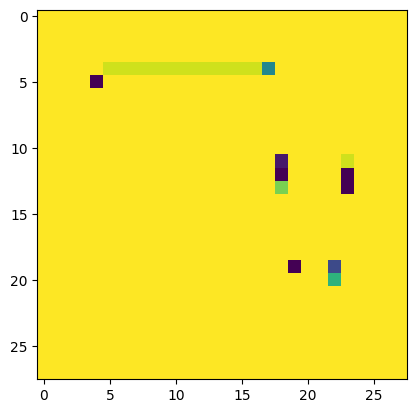

In [6]:
plt.imshow(train_imgs[2,0,:,:])

In [7]:
input_size =28
hidden_size = [28,64,128,128,256]
output_size =4
batch_size=16

In [8]:
kernel_size = 4
stride = 1
padding = 0
init_kernel = 16

In [9]:
## AutoEncoder 클래스 구현 
class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(VariationalAutoEncoder, self).__init__()
        ## initialize
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.Relu = nn.RReLU()
        self.flatten = nn.Flatten()
        ##오토인코더 구현
        
        self.fc_mu = nn.Linear(output_size,output_size)
        self.fc_var =nn.Linear(output_size,output_size)
        
        ## 인코더 부분
        self.input_en_layer = nn.Conv2d(
            in_channels=1, out_channels=init_kernel, kernel_size=kernel_size, 
            stride=stride, padding=padding)
        #self.bn1 = nn.BatchNorm2d(hidden_size[0])
        self.input_en_layer_2 = nn.Conv2d(
            in_channels=init_kernel, out_channels=init_kernel*2, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        #self.bn2 = nn.BatchNorm2d(hidden_size[1])
        self.input_en_layer_3 = nn.Conv2d(
            in_channels=init_kernel*2, out_channels=init_kernel*4, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        #self.bn3 = nn.BatchNorm2d(hidden_size[2])
        self.input_en_layer_4 = nn.Conv2d(
            in_channels=init_kernel*4, out_channels=init_kernel*8, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        #self.bn4 = nn.BatchNorm2d(hidden_size[3])
        self.input_en_layer_5 = nn.Conv2d(
            in_channels=init_kernel*8, out_channels=init_kernel, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        #self.bn5 = nn.BatchNorm2d(hidden_size[4])
        self.output_en_layer = nn.Linear(32768, output_size)
        
        #log_var = 
        
        ## 디코더 부분
        self.input_dic_layer = nn.ConvTranspose2d(
            in_channels=1, out_channels=init_kernel*8, kernel_size=2, 
            stride=stride, padding=padding
        )
        self.input_dic_layer_5 = nn.ConvTranspose2d(
            in_channels=init_kernel, out_channels=init_kernel*8, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self
        self.input_dic_layer_4 = nn.ConvTranspose2d(
            in_channels=init_kernel*8, out_channels=init_kernel*4, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.input_dic_layer_3 = nn.ConvTranspose2d(
            in_channels=init_kernel*4, out_channels=init_kernel*2, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.input_dic_layer_2 = nn.ConvTranspose2d(
            in_channels=init_kernel*2, out_channels=init_kernel, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        
        self.output_dic_layer = nn.ConvTranspose2d(
            in_channels=16, out_channels=1, kernel_size=kernel_size, 
            stride=2, padding=padding
        )
        
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))
        self.mu = 0
        self.z = 0
        self.log_var = 0
        
        
    def encode(self,inputs):
        x = (self.input_en_layer(inputs))
        x = self.Relu(x)
        
        x = (self.input_en_layer_2(x))
        x = self.Relu(x)

        x = (self.input_en_layer_3(x))

        x = self.Relu(x)
        x = (self.input_en_layer_4(x))
        x = self.Relu(x)
        x = self.flatten(x)
        output = self.output_en_layer(x) 
        
        return output
    
    def decode(self,output):
        output = self.input_dic_layer(output)
        output = (self.input_dic_layer_4(output))
        output = self.Relu(output)
        output = (self.input_dic_layer_3(output))
        output = self.Relu(output)
        output = (self.input_dic_layer_2(output))
        output = self.Relu(output)
        
        output = self.output_dic_layer(output)
        output = nn.ZeroPad2d(1)(output)
        
        
        return output
    
    def gaussian_likelihood(self,x_hat,x):
        scale=  torch.exp(torch.tensor(self.log_scale))
        mean = x_hat
        dist = torch.distributions.Normal(mean,scale)
        
        log_pxz = dist.log_prob(x)
        
        return log_pxz.sum(dim=(1))
        
 
    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)

        # sum over last dim to go from single dim distribution to multi-dim
        kl = kl.sum(-1)
        return kl
    
    def forwardV2(self, inputs): 
        output = self.encode(inputs)
        self.mu = self.fc_mu(output)
        self.log_var = self.fc_var(output)
        std = torch.exp(self.log_var/2)
        q = torch.distributions.Normal(self.mu,std)
        z = q.rsample()
        z = z.view([-1,1,2,2])
        
        x_hat = self.decode(z)

        
        return x_hat
    
    
    def forward(self, inputs): 
        output = self.encode(inputs)
        self.mu = self.fc_mu(output)
        self.log_var = self.fc_var(output)
        std = torch.exp(self.log_var/2)
        q = torch.distributions.Normal(self.mu,std)
        z = q.rsample()
        z = z.view([-1,1,2,2])
        
        x_hat = self.decode(z)
        recon_loss = self.gaussian_likelihood(x_hat,inputs)
        z = z.view([-1,4])
        kl =  self.kl_divergence(z,self.mu,std)
        elbo = (kl - recon_loss.mean(dim=1).mean(dim=1))
        elbo = elbo.mean()
        
        return elbo
    

In [10]:
MSELoss = nn.MSELoss()
## 매개변수 조정 방식으로 Adam사용
optimizer = torch.optim.Adam
VAE = VariationalAutoEncoder(input_size,hidden_size, output_size)
optim = optimizer(VAE.parameters())

In [11]:
train_dataloader = DataLoader(train_imgs, batch_size=16,
                                         shuffle=True)

In [12]:
Adam = optimizer(VAE.parameters(), lr =0.0001,weight_decay=0.00005)
## 배치 학습을 시키기 위한 데이터 변환
data_iter = train_dataloader
## 에포크 학습
vae_train_loss =[]
VAE.train()
for ep in range(1, 10 +1):
    running_loss =0.0
    for x in data_iter:
        ## 매개변수 0으로 초기화
        Adam.zero_grad()
        x = torch.tensor(x,dtype=torch.float32)
        loss = VAE.forward(x)
        
        #loss += MSELoss(output,x)
        loss.backward()
        
        
        Adam.step()
        running_loss += loss.item()
    vae_train_loss.append(running_loss/batch_size)
    ## 각 에포크마다 손실 값 표기
    if ep%10==0:
        print("epoch: {}, loss: {:.2f}".format(ep, running_loss))

C:\Users\john\AppData\Local\Temp\ipykernel_42132\1584045760.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x,dtype=torch.float32)
C:\Users\john\AppData\Local\Temp\ipykernel_42132\4179058485.py:112: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scale=  torch.exp(torch.tensor(self.log_scale))


epoch: 10, loss: 9.43


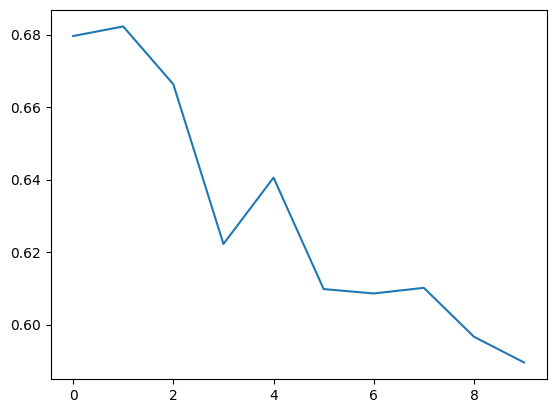

In [13]:
plt.plot(vae_train_loss)

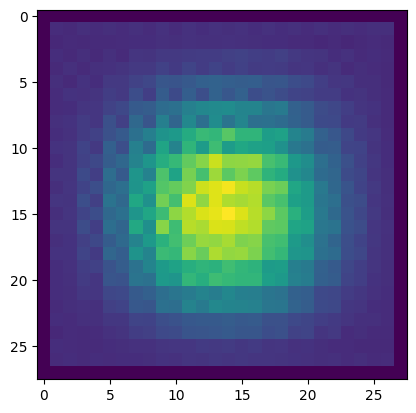

In [14]:
plt.imshow(VAE.forwardV2(torch.FloatTensor(train_imgs[:3]))[0,0,:,:].detach().numpy())